In [1]:
# import libraries

import seaborn as sns
import xarray as xr
import numpy as np
import pandas as pd
import intake
import dask
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings("ignore")
ds = xr.open_dataset('../local_data/atmos_daily.nc', chunks={"time": 10})
ds

<xarray.Dataset> Size: 12GB
Dimensions:        (lon: 128, lonb: 129, lat: 64, latb: 65, time: 1080, nv: 2,
                    pfull: 40, phalf: 41)
Coordinates:
  * lon            (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * lonb           (lonb) float64 1kB -1.406 1.406 4.219 ... 353.0 355.8 358.6
  * lat            (lat) float64 512B -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * latb           (latb) float64 520B -90.0 -86.58 -83.76 ... 83.76 86.58 90.0
  * time           (time) object 9kB 0001-01-01 12:00:00 ... 0003-12-30 12:00:00
  * nv             (nv) float64 16B 1.0 2.0
  * pfull          (pfull) float64 320B 0.01722 0.07865 0.1807 ... 814.9 935.0
  * phalf          (phalf) float64 328B 0.0 0.04682 0.1155 ... 759.6 871.5 1e+03
Data variables: (12/18)
    ps             (time, lat, lon) float32 35MB dask.array<chunksize=(10, 64, 128), meta=np.ndarray>
    precipitation  (time, lat, lon) float32 35MB dask.array<chunksize=(10, 64, 128), meta=np.ndarray>
    t_surf         (time, lat, lon) float32 35MB dask.array<chunksize=(10, 64, 128), meta=np.ndarray>
    flux_t         (time, lat, lon) float32 35MB dask.array<chunksize=(10, 64, 128), meta=np.ndarray>
    flux_lhe       (time, lat, lon) float32 35MB dask.array<chunksize=(10, 64, 128), meta=np.ndarray>
    rh             (time, pfull, lat, lon) float32 1GB dask.array<chunksize=(10, 40, 64, 128), meta=np.ndarray>
    ...             ...
    div            (time, pfull, lat, lon) float32 1GB dask.array<chunksize=(10, 40, 64, 128), meta=np.ndarray>
    zsurf          (lat, lon) float32 33kB dask.array<chunksize=(64, 128), meta=np.ndarray>
    average_T1     (time) object 9kB dask.array<chunksize=(10,), meta=np.ndarray>
    average_T2     (time) object 9kB dask.array<chunksize=(10,), meta=np.ndarray>
    average_DT     (time) timedelta64[ns] 9kB dask.array<chunksize=(10,), meta=np.ndarray>
    time_bounds    (time, nv) timedelta64[ns] 17kB dask.array<chunksize=(10, 2), meta=np.ndarray>
Attributes:
    filename:   atmos_daily.nc
    title:      FMS Model results
    grid_type:  regular
    grid_tile:  N/A

In [3]:
# mask out mountains
import numpy as np
Rd = 287.05
g0 = 9.80665
T0 = 270.0  # K
H = (Rd * T0) / g0

p = ds['pfull']
if p.max() < 2000:
    p_pa = p * 100.0
else:
    p_pa = p

ps = 1e5
z_levels = H * np.log(ps / p_pa)   
# height of each pressure level (m)

# Broadcast and mask
mask = z_levels >= ds.zsurf
v_masked = ds.where(mask)

In [4]:
v_masked

<xarray.Dataset> Size: 33GB
Dimensions:        (time: 1080, lat: 64, lon: 128, pfull: 40, nv: 2, lonb: 129,
                    latb: 65, phalf: 41)
Coordinates:
  * lon            (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * lonb           (lonb) float64 1kB -1.406 1.406 4.219 ... 353.0 355.8 358.6
  * lat            (lat) float64 512B -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * latb           (latb) float64 520B -90.0 -86.58 -83.76 ... 83.76 86.58 90.0
  * time           (time) object 9kB 0001-01-01 12:00:00 ... 0003-12-30 12:00:00
  * nv             (nv) float64 16B 1.0 2.0
  * pfull          (pfull) float64 320B 0.01722 0.07865 0.1807 ... 814.9 935.0
  * phalf          (phalf) float64 328B 0.0 0.04682 0.1155 ... 759.6 871.5 1e+03
Data variables: (12/18)
    ps             (time, lat, lon, pfull) float32 1GB dask.array<chunksize=(10, 64, 128, 40), meta=np.ndarray>
    precipitation  (time, lat, lon, pfull) float32 1GB dask.array<chunksize=(10, 64, 128, 40), meta=np.ndarray>
    t_surf         (time, lat, lon, pfull) float32 1GB dask.array<chunksize=(10, 64, 128, 40), meta=np.ndarray>
    flux_t         (time, lat, lon, pfull) float32 1GB dask.array<chunksize=(10, 64, 128, 40), meta=np.ndarray>
    flux_lhe       (time, lat, lon, pfull) float32 1GB dask.array<chunksize=(10, 64, 128, 40), meta=np.ndarray>
    rh             (time, pfull, lat, lon) float32 1GB dask.array<chunksize=(10, 40, 64, 128), meta=np.ndarray>
    ...             ...
    div            (time, pfull, lat, lon) float32 1GB dask.array<chunksize=(10, 40, 64, 128), meta=np.ndarray>
    zsurf          (lat, lon, pfull) float32 1MB dask.array<chunksize=(64, 128, 40), meta=np.ndarray>
    average_T1     (time, pfull, lat, lon) object 3GB dask.array<chunksize=(10, 40, 64, 128), meta=np.ndarray>
    average_T2     (time, pfull, lat, lon) object 3GB dask.array<chunksize=(10, 40, 64, 128), meta=np.ndarray>
    average_DT     (time, pfull, lat, lon) timedelta64[ns] 3GB dask.array<chunksize=(10, 40, 64, 128), meta=np.ndarray>
    time_bounds    (time, nv, pfull, lat, lon) timedelta64[ns] 6GB dask.array<chunksize=(10, 2, 40, 64, 128), meta=np.ndarray>
Attributes:
    filename:   atmos_daily.nc
    title:      FMS Model results
    grid_type:  regular
    grid_tile:  N/A

In [19]:
# start plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

sns.set_style('white')
sns.despine(left=True, right=True, top=True, bottom=True)

cmap = plt.get_cmap("RdBu_r").copy()
cmap.set_bad(color='darkgray')

<Figure size 640x480 with 0 Axes>

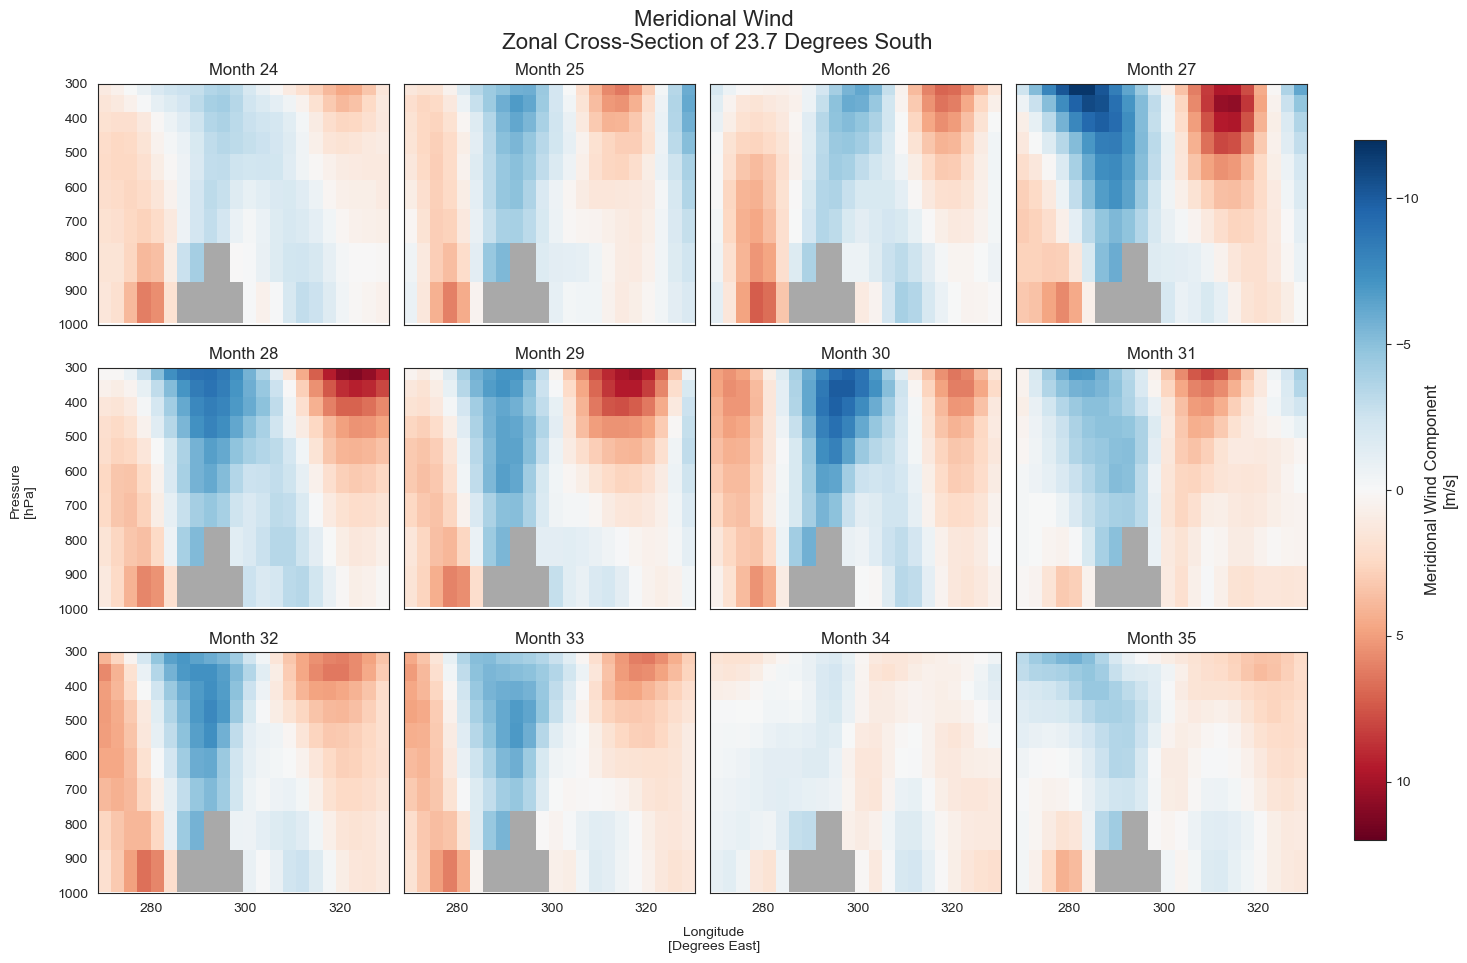

In [32]:
# VComp — Meridional Wind Component
vcomp_months = v_masked.vcomp.coarsen(time=30, boundary='trim').mean().compute()

# Create subplots: 3 rows × 4 columns = 12 months
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=True, sharey=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through months 12–23
for i, t in enumerate(range(24, 36)):
    ax = axes[i]
    v = vcomp_months.isel(time=t).sel(lat=-23, method='nearest').sel(lon=slice(270, 330))
    v.plot(ax=ax, x='lon', y='pfull', yincrease=False, add_colorbar=False, vmin=-12, vmax=12, cmap=cmap, add_labels=False)
    
    ax.set_title(f'Month {t}')
    ax.set_ylim(1000, 300)


# Add a shared colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
mappable = v.plot(
    x='lon', y='pfull', yincrease=False,
    add_colorbar=True, cbar_ax=cbar_ax,
    vmin=-12, vmax=12, cmap="RdBu_r", add_labels=False
)
mappable.colorbar.set_label("Meridional Wind Component\n[m/s]", fontsize=12)

# Add shared labels
fig.suptitle('Meridional Wind\n Zonal Cross-Section of 23.7 Degrees South', fontsize=16)
fig.text(0.5, 0.04, 'Longitude\n[Degrees East]', ha='center')
fig.text(0.06, 0.5, 'Pressure\n[hPa]', va='center', rotation='vertical')

plt.tight_layout(rect=[0.08, 0.06, 0.88, 1])
plt.savefig('../figures/idealized cross-sections/Meridional-Wind.png')
plt.show()


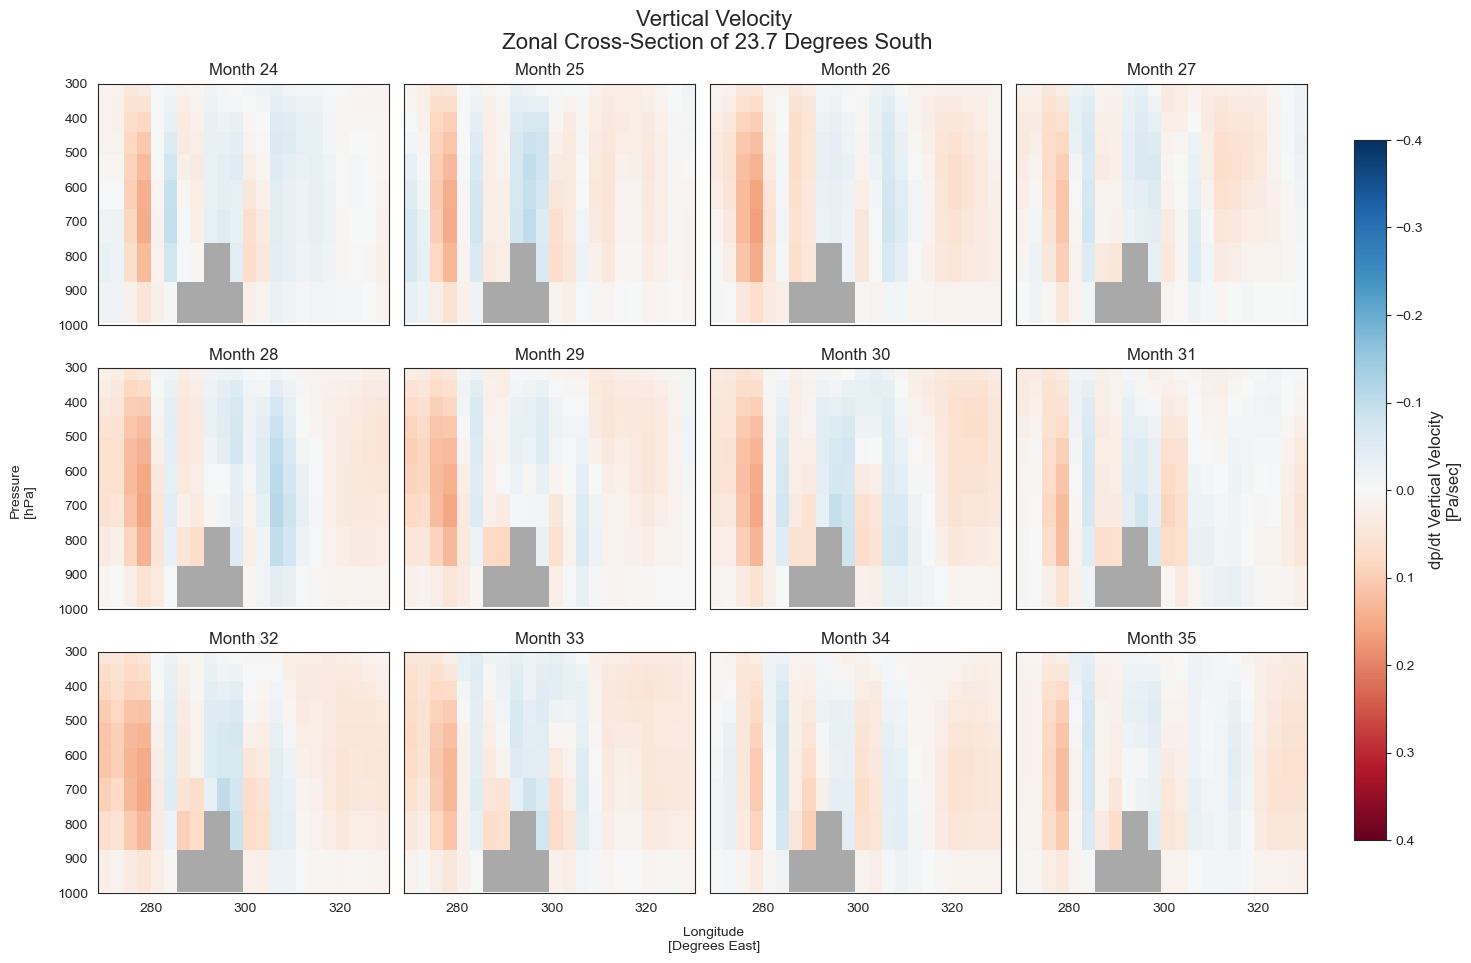

In [40]:
# Omega — Vertical Velocity
omega_months = v_masked.omega.coarsen(time=30, boundary='trim').mean().compute()

# plotting
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=True, sharey=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through months 12–23
for i, t in enumerate(range(24, 36)):
    ax = axes[i]
    vor = omega_months.isel(time=t).sel(lat=-23, method='nearest').sel(lon=slice(270, 330))
    vor.plot(ax=ax, x='lon', y='pfull', yincrease=False, add_colorbar=False, vmin=-0.4, vmax=0.4, cmap=cmap, add_labels=False)
    
    ax.set_title(f'Month {t}')
    ax.set_ylim(1000, 300)


# Add a shared colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
mappable = vor.plot(
    x='lon', y='pfull', yincrease=False,
    add_colorbar=True, cbar_ax=cbar_ax,
    vmin=-0.4, vmax=0.4, cmap="RdBu_r", add_labels=False
)
mappable.colorbar.set_label("dp/dt Vertical Velocity\n[Pa/sec]", fontsize=12)

# Add shared labels
fig.suptitle('Vertical Velocity\n Zonal Cross-Section of 23.7 Degrees South', fontsize=16)
fig.text(0.5, 0.04, 'Longitude\n[Degrees East]', ha='center')
fig.text(0.06, 0.5, 'Pressure\n[hPa]', va='center', rotation='vertical')

plt.tight_layout(rect=[0.08, 0.06, 0.88, 1])
plt.savefig('../figures/idealized cross-sections/Vertical-Velocity.png')
plt.show()

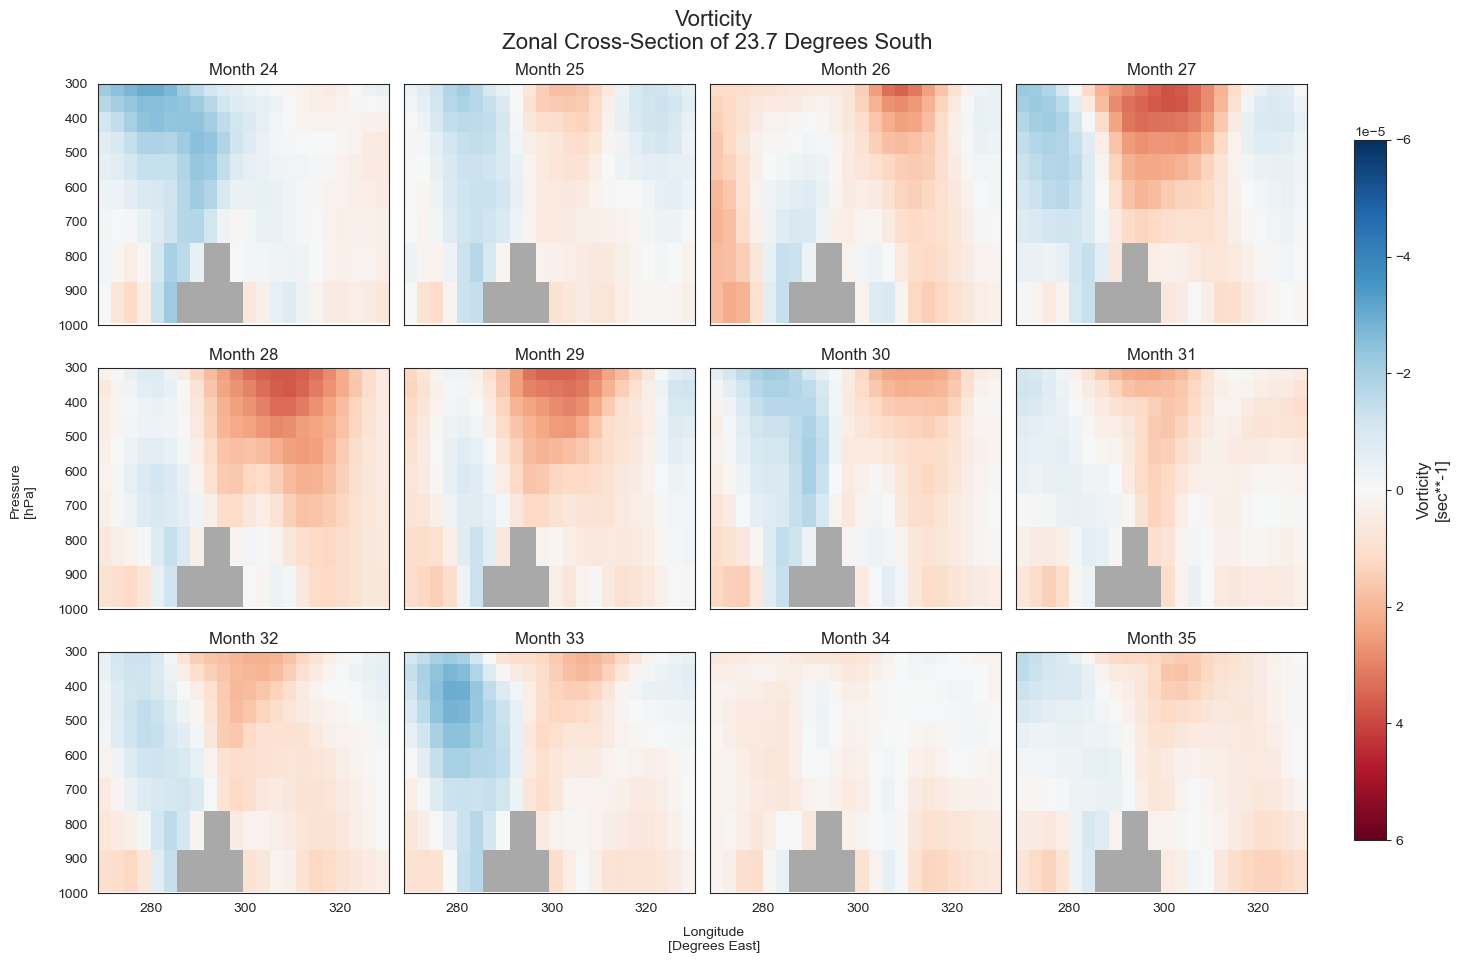

In [41]:
# Vort — Vorticity — Curl of Velocity
vor_months = v_masked.vor.coarsen(time=30, boundary='trim').mean().compute()

# plotting
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=True, sharey=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through months 12–23
for i, t in enumerate(range(24, 36)):
    ax = axes[i]
    vor = vor_months.isel(time=t).sel(lat=-23, method='nearest').sel(lon=slice(270, 330))
    vor.plot(ax=ax, x='lon', y='pfull', yincrease=False, add_colorbar=False, cmap=cmap, add_labels=False, vmin=-0.00006, vmax=0.00006) 
    
    ax.set_title(f'Month {t}')
    ax.set_ylim(1000, 300)


# Add a shared colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
mappable = vor.plot(
    x='lon', y='pfull', yincrease=False,
    add_colorbar=True, cbar_ax=cbar_ax,
    cmap="RdBu_r", add_labels=False,
    vmin=-0.00006, vmax=0.00006
)

mappable.colorbar.set_label("Vorticity\n[sec**-1]", fontsize=12)

# Add shared labels
fig.suptitle('Vorticity\n Zonal Cross-Section of 23.7 Degrees South', fontsize=16)
fig.text(0.5, 0.04, 'Longitude\n[Degrees East]', ha='center')
fig.text(0.06, 0.5, 'Pressure\n[hPa]', va='center', rotation='vertical')

plt.tight_layout(rect=[0.08, 0.06, 0.88, 1])
plt.savefig('../figures/idealized cross-sections/Vorticity.png')
plt.show()

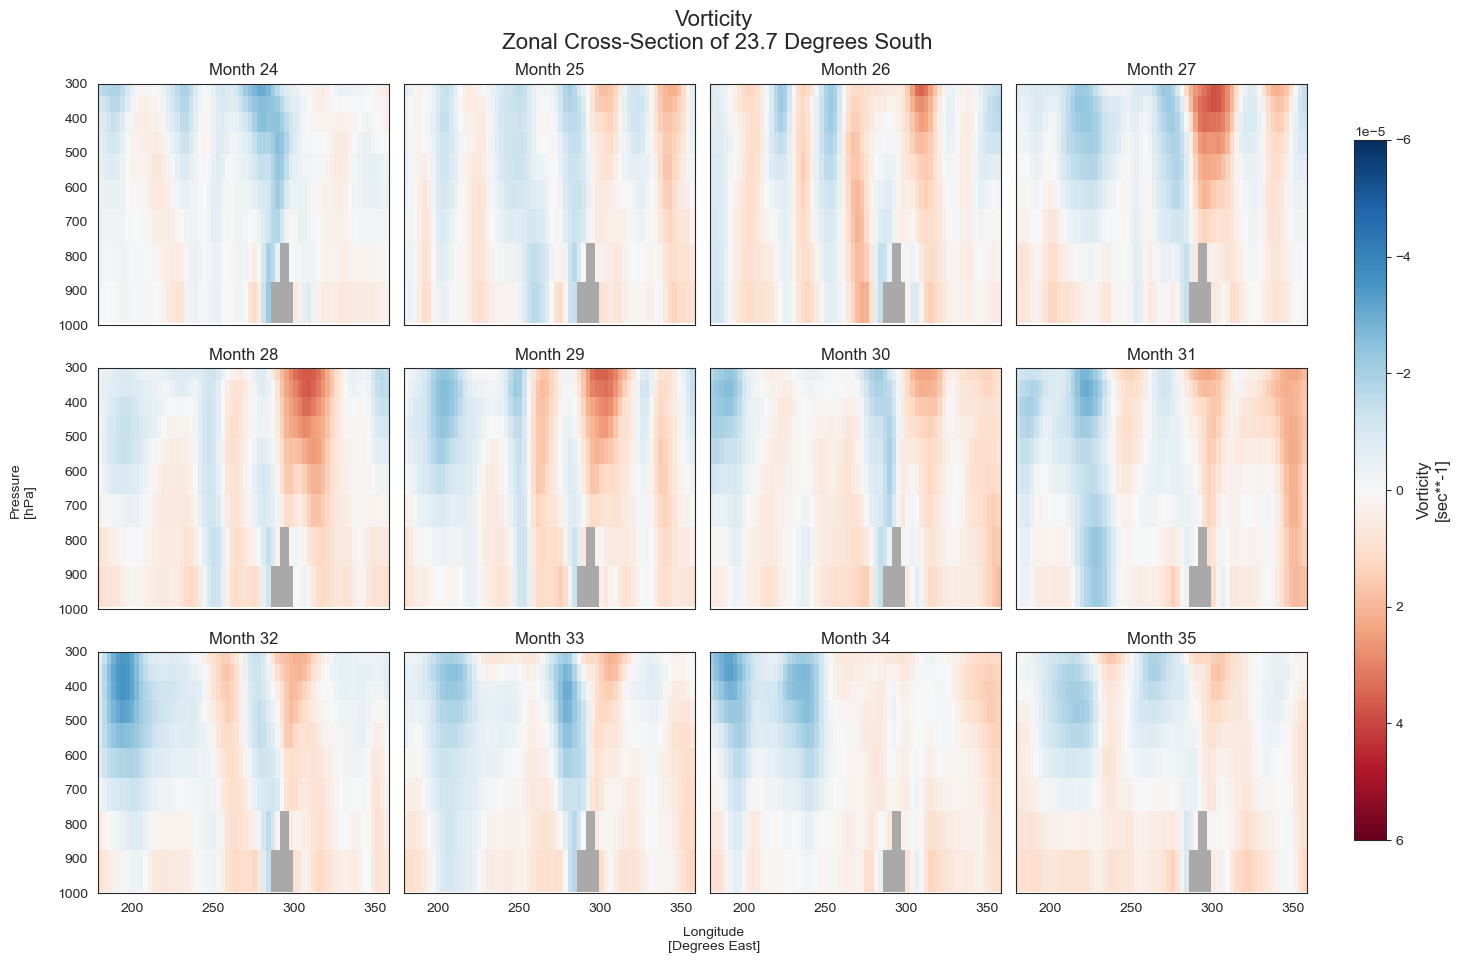

In [43]:
# Vort — Vorticity — Curl of Velocity — Wide Scale
vor_months = v_masked.vor.coarsen(time=30, boundary='trim').mean().compute()

# plotting
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=True, sharey=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through months 12–23
for i, t in enumerate(range(24, 36)):
    ax = axes[i]
    vor = vor_months.isel(time=t).sel(lat=-23, method='nearest').sel(lon=slice(180, 360))
    vor.plot(ax=ax, x='lon', y='pfull', yincrease=False, add_colorbar=False, cmap=cmap, add_labels=False, vmin=-0.00006, vmax=0.00006) 
    
    ax.set_title(f'Month {t}')
    ax.set_ylim(1000, 300)


# Add a shared colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
mappable = vor.plot(
    x='lon', y='pfull', yincrease=False,
    add_colorbar=True, cbar_ax=cbar_ax,
    cmap="RdBu_r", add_labels=False,
    vmin=-0.00006, vmax=0.00006
)

mappable.colorbar.set_label("Vorticity\n[sec**-1]", fontsize=12)

# Add shared labels
fig.suptitle('Vorticity\n Zonal Cross-Section of 23.7 Degrees South', fontsize=16)
fig.text(0.5, 0.04, 'Longitude\n[Degrees East]', ha='center')
fig.text(0.06, 0.5, 'Pressure\n[hPa]', va='center', rotation='vertical')

plt.tight_layout(rect=[0.08, 0.06, 0.88, 1])
plt.savefig('../figures/idealized cross-sections/Vorticity.png')
plt.show()

In [ ]:
# calculate Equatorial Kelvin Waves?